<a href="https://colab.research.google.com/github/ben-wycliff/dl-final-exam/blob/main/results_with_best_model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!unzip -q "/content/drive/MyDrive/deep learning final exam/data.zip"

In [ ]:
!pip install tf-explain

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.6/43.6 kB 4.0 MB/s eta 0:00:00


In [ ]:
import os
import random
import numpy as np
import tensorflow as tf

import keras
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential
from keras.layers import (Dense,
                          Dropout,
                          GlobalAveragePooling2D)
from keras.callbacks import ModelCheckpoint, TensorBoard
from keras.applications import VGG16

from sklearn.metrics import (classification_report,
                             confusion_matrix,
                             ConfusionMatrixDisplay,
                             roc_curve,
                             auc)

from tf_explain.core.grad_cam import GradCAM

import matplotlib.pyplot as plt
import matplotlib.colors as colors

random.seed(0)

In [ ]:
# Set the path to your dataset
test_dir = 'data/test'

# Set the input image dimensions
input_shape = (224, 224)

# Set batch size
batch_size = 32

# Set the number of classes
num_classes = 6

# Create an ImageDataGenerator for normalization and grayscale conversion
data_generator = ImageDataGenerator(rescale=1.0/255.0)

# Create testing data iterator
test_iterator = data_generator.flow_from_directory(
    test_dir,
    target_size=input_shape,
    # color_mode='grayscale',
    class_mode='categorical',
    batch_size=batch_size,
    shuffle=False
)

Found 600 images belonging to 6 classes.


In [ ]:
# Define the base pre-trained model
base_model = VGG16(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# Freeze the layers of the base model
for layer in base_model.layers[:15]:
    layer.trainable = False

GA_Pool = GlobalAveragePooling2D()(base_model.layers[-1].output)
dense  = Dense(256, activation='relu')(GA_Pool)
dropout = Dropout(0.5)(dense)
output = Dense(6, activation='softmax')(dropout)
model = keras.models.Model(inputs=base_model.inputs, outputs=output)
model.summary()

# load saved model weights
model_weights_path = "/content/drive/MyDrive/deep learning "\
                     "final exam/Models/VGG16/model_checkpoint.h5"

model.load_weights(model_weights_path)

58889256/58889256 [==============================] - 3s 0us/step
Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                              

In [ ]:
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0     

In [ ]:
def plot_confusion_matrix(y_test, y_pred, labels, figsize=(8, 8), normalize=None):
  """
    y_test: true y labels
    y_pred: predicted y labels
    labels: class labels
  """
  disp = ConfusionMatrixDisplay.from_predictions(y_test,
                                                 y_pred,
                                                 display_labels=labels,
                                                 cmap="Blues",
                                                 normalize=normalize)
  fig = disp.figure_
  fig.set_figwidth(figsize[1])
  fig.set_figheight(figsize[0])

In [ ]:
# make predictions
pred_probs = model.predict(test_iterator)
y_pred = np.argmax(pred_probs, axis=1)

# Generate classification report and confusion matrix
y_true = test_iterator.classes
class_names = list(test_iterator.class_indices.keys())

19/19 [==============================] - 18s 339ms/step


In [ ]:
# Classification report
print(classification_report(y_true, y_pred, target_names=class_names))

              precision    recall  f1-score   support

      Glioma       0.88      0.98      0.92       100
  Meningioma       0.96      0.96      0.96       100
      NORMAL       0.95      0.95      0.95       100
 Neurocitoma       0.99      0.98      0.98       100
      Outros       1.00      0.92      0.96       100
  Schwannoma       0.99      0.96      0.97       100

    accuracy                           0.96       600
   macro avg       0.96      0.96      0.96       600
weighted avg       0.96      0.96      0.96       600



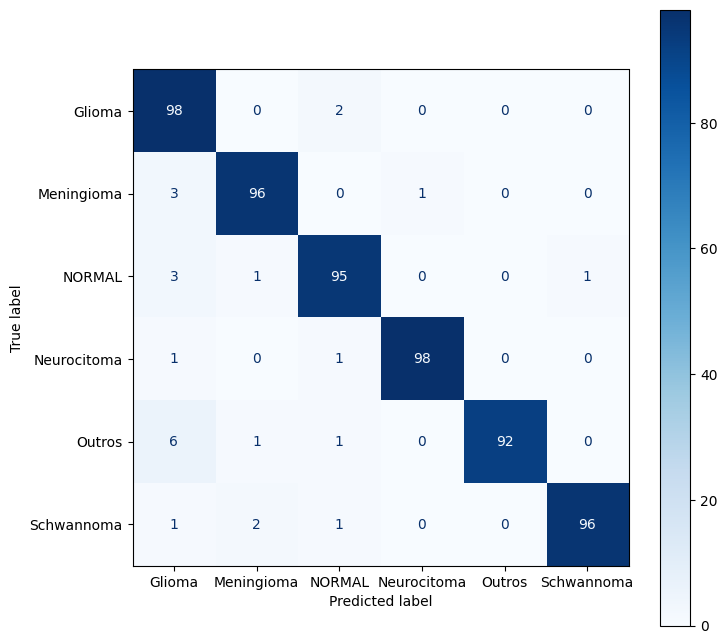

In [ ]:
plot_confusion_matrix(y_true, y_pred, class_names)

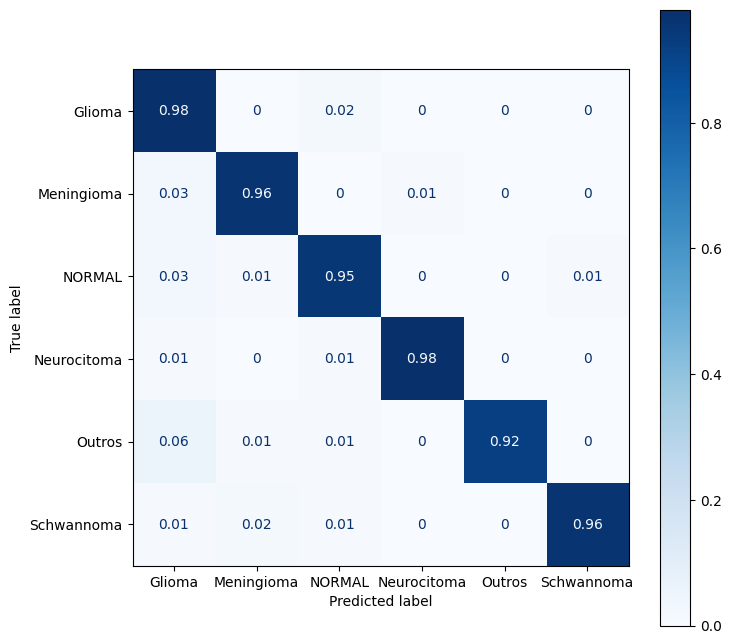

In [ ]:
plot_confusion_matrix(y_true, y_pred, class_names, normalize='true')

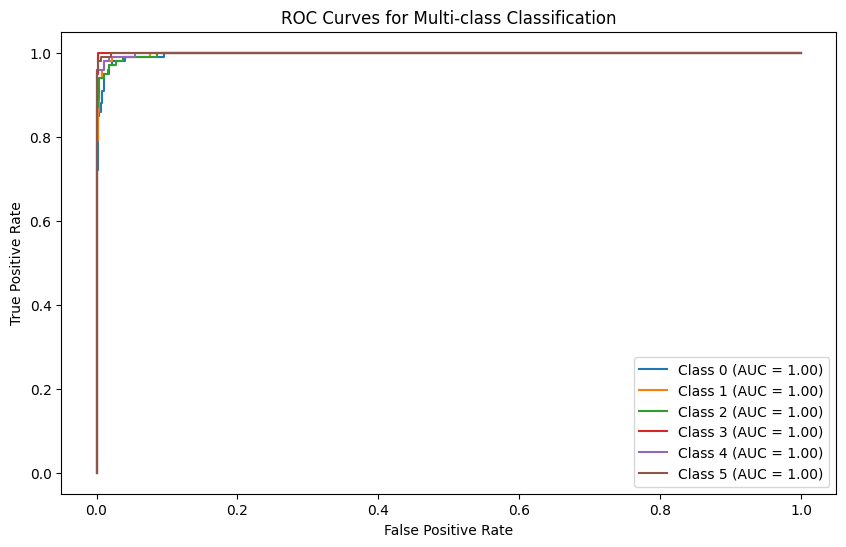

In [ ]:

# Assuming you have the true labels for the samples in a numpy array called 'true_labels'

n_classes = 6

# Initialize lists to store false positive rates (FPR) and true positive rates (TPR) for each class
fpr_list = []
tpr_list = []
roc_auc_list = []

# Iterate over each class
for class_index in range(n_classes):
    # Get the predicted probabilities for the current class
    class_probs = pred_probs[:, class_index]

    # Create binary labels for the current class
    class_labels = (y_true == class_index).astype(int)

    # Compute the false positive rate (FPR) and true positive rate (TPR)
    fpr, tpr, _ = roc_curve(class_labels, class_probs)

    # Calculate the Area Under the ROC Curve (AUC-ROC)
    roc_auc = auc(fpr, tpr)

    # Append the FPR, TPR, and AUC-ROC values to the lists
    fpr_list.append(fpr)
    tpr_list.append(tpr)
    roc_auc_list.append(roc_auc)

# Plot the ROC curves for each class
plt.figure(figsize=(10, 6))

# Iterate over each class
for class_index in range(n_classes):
    # Plot the ROC curve for the current class
    plt.plot(fpr_list[class_index], tpr_list[class_index],
             label=f'Class {class_index} (AUC = {roc_auc_list[class_index]:.2f})')

# Set labels and title for the plot
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curves for Multi-class Classification')
plt.legend(loc='lower right')

# Show the plot
plt.show()

In [ ]:
def img_prep(path, shape):
  img = tf.keras.preprocessing.image.load_img(path, target_size=input_shape)
  img_array = tf.keras.preprocessing.image.img_to_array(img)
  return np.expand_dims(img_array, axis=0), img

def gen_heatmap_exptn(img, label):
  # Create the GradCAM explainer and generate heatmaps
  explainer = GradCAM()
  heatmap = explainer.explain(((img/ 255.0).astype(np.float32), label), model, layer_name='block5_conv3', class_index=5)
  # plt.imshow(img, cmap="gray")
  heatmap_normalized = (heatmap - np.min(heatmap)) / (np.max(heatmap) - np.min(heatmap))
  # Convert the multi-channel heatmap to a single-channel grayscale heatmap
  return np.max(heatmap_normalized, axis=-1)

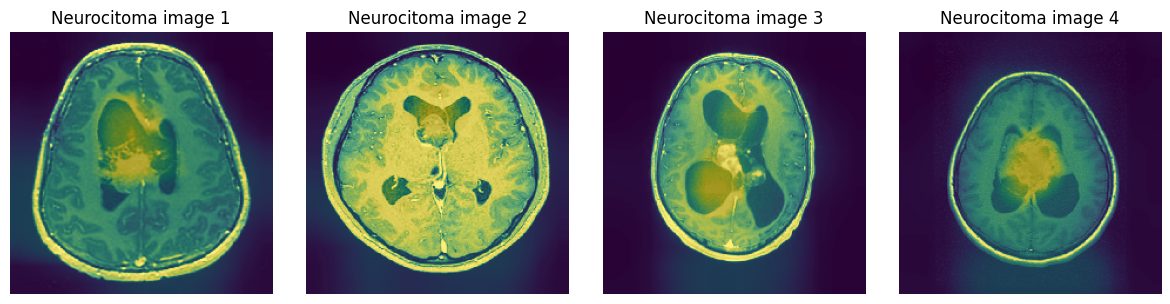

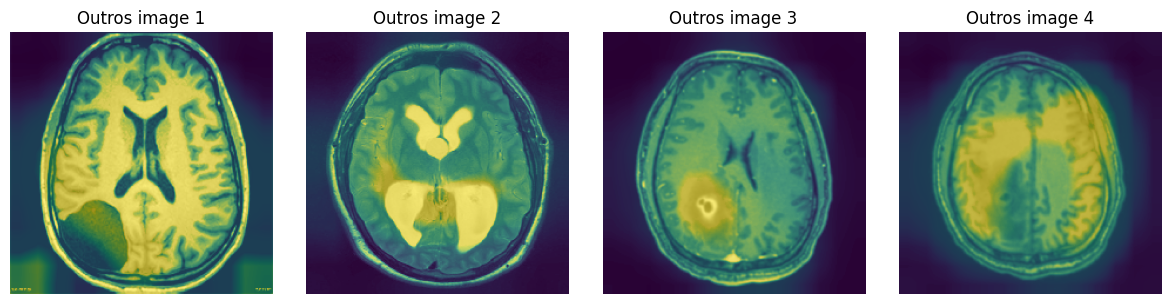

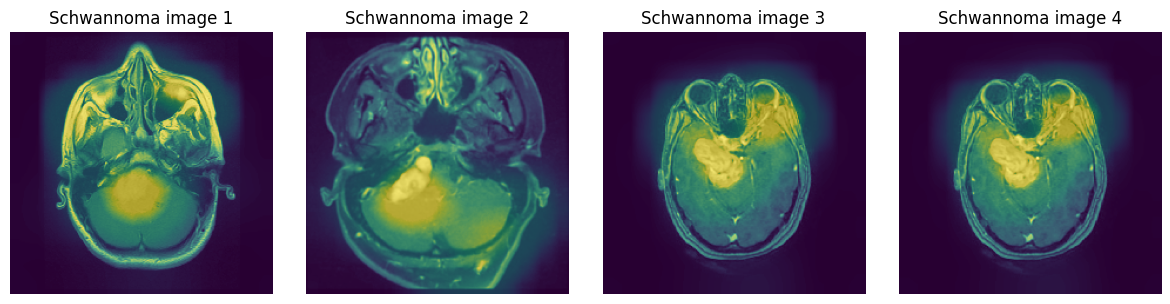

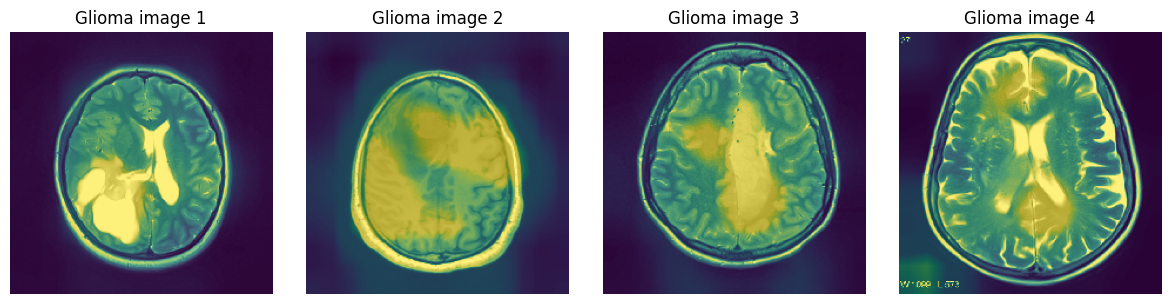

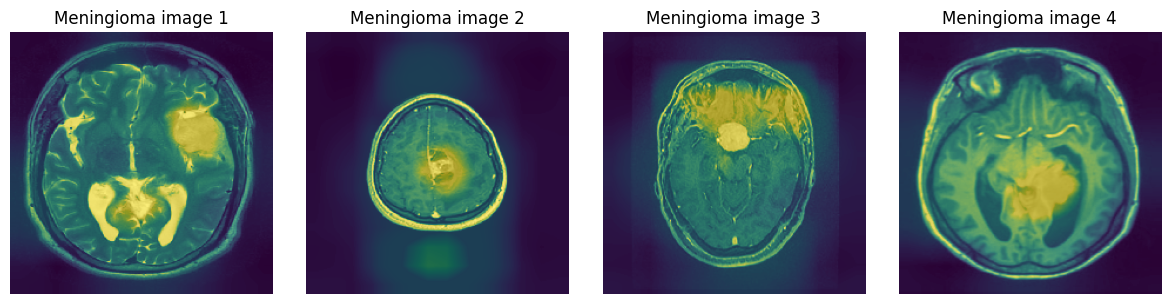

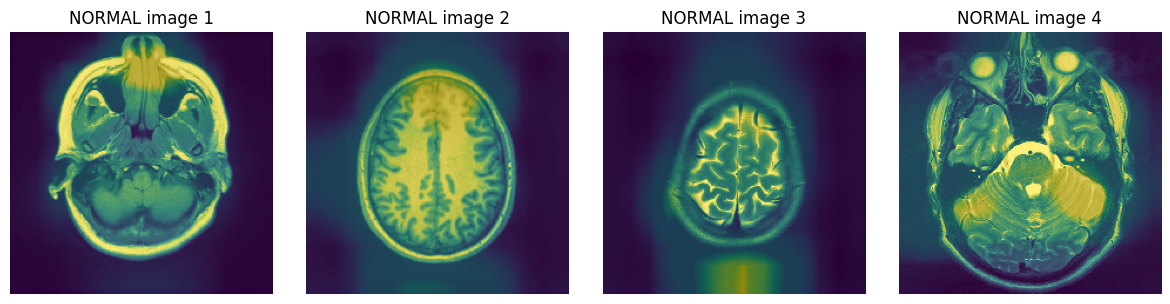

In [34]:
classes = os.listdir("data/test")

for c in classes:
  c_path = os.path.join("data/test", c)
  c_images = os.listdir(c_path)
  imgs = random.choices(c_images, k=4)

  fig, axes = plt.subplots(1, 4, figsize=(12, 3))

  for i, image_file in enumerate(imgs):
    image_path = os.path.join(c_path, image_file)
    batch, image = img_prep(image_path, (256, 256))
    image_heatmap = gen_heatmap_exptn(batch, c)

    # Display the heatmap overlayed on image
    axes[i].imshow(image, cmap="gray")
    axes[i].imshow(image_heatmap, cmap="viridis", alpha=0.6)
    axes[i].axis("off")
    axes[i].set_title(f"{c} image {i+1}")

  plt.tight_layout()
  plt.show()